# VAR India

Vector auto-regressive models - VAR, VMA, VARIMA on Covid-19 Cases. For all models, the first-differenced dataset is used (I = 1).

## [Setup](#setup)
1. [Imports](#imports)
2. [Results table](#results_init)
3. [Ingestion](#ingestion)
4. [Plotting](#plotting_init)
5. [Statistical tests](#stattests1)
    1. [Johansen co-integration test](#jci_init)
    2. [Augmented DF Test](#adf_init)
6. [Differencing](#diff_init)
7. [Train test split](#traintest_init)

## Long-Term Forecasting

### [VAR Model](#var_model)
1. [Find order p of VAR](#var_p)
2. [VAR(1) Model](#var1)
3. [Plots of first differenced predictions](#diff_plot_var)
4. [Undifferencing and plotting](#undiff_var)
5. [Store metrics - MAE, MAPE, MSE](#store_var)
6. [Plot Train, Test, Forecast](#plot_final_var)

    
### [VMA Model](#vma_model)
1. [Find order q of VMA](#vma_q)
2. [VMA(1) Model](#vma1)
3. [Plots of first differenced predictions](#diff_plot_vma)
4. [Undifferencing and plotting](#undiff_vma)
5. [Store metrics - MAE, MAPE, MSE](#store_vma)
6. [Plot Train, Test, Forecast](#plot_final_vma)


### [VARMA Model](#varma_model)
1. [Find order (p, q) of VARMA](#varma_pq)
2. [VARMA(1, 1) Model](#varma11)
3. [Plots of first differenced predictions](#diff_plot_varma)
4. [Undifferencing and plotting](#undiff_varma)
5. [Store metrics - MAE, MAPE, MSE](#store_varma)
6. [Plot Train, Test, Forecast](#plot_final_varma)

## [Short-Term/Rolling Forecasting](#shortterm)

1. [VAR(1)](#var_roll)
2. [VMA(1)](#vma_roll)
3. [VARMA(1,1)](#varma_roll)

## [Final Metrics](#final_results)

<a name=setup></a>

# Setup

<a name=imports></a>
## Imports

In [84]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings

import preprocessing
import plotting
import stats_testing
import metrics

# warnings.filterwarnings("ignore")

<a name=results_init></a>
## Results table

In [85]:
results_columns = ['model', 'mse', 'mape', 'mae']
results_table = pd.DataFrame(columns=results_columns)

<a name=ingestion></a>

## Ingestion

In [86]:
daily_cases_india = pd.read_csv('../../cleaned_datasets/india/daily_cases_india.csv', parse_dates=['Date'])
# daily_vacc_india = pd.read_csv('../../cleaned_datasets/india/daily_vacc_india.csv', parse_dates=['date'])
cum_vacc_india = pd.read_csv('../../cleaned_datasets/india/cum_vacc_india.csv', parse_dates=['date'])
population = pd.read_csv('../../cleaned_datasets/world_population.csv', index_col='iso_code')

In [87]:
daily_cases_india.dtypes

Date         datetime64[ns]
Confirmed           float64
Deaths              float64
Recovered           float64
dtype: object

In [88]:
daily_cases_india

,Date,Confirmed,Deaths,Recovered
0,2020-01-30,NaN,NaN,NaN
1,2020-01-31,0.0,0.0,0.0
2,2020-02-01,0.0,0.0,0.0
3,2020-02-02,1.0,0.0,0.0
4,2020-02-03,1.0,0.0,0.0
...,...,...,...,...
707,2022-01-06,117100.0,302.0,0.0
708,2022-01-07,141986.0,285.0,0.0
709,2022-01-08,159632.0,327.0,0.0
710,2022-01-09,179723.0,146.0,0.0


In [89]:
cum_vacc_india.dtypes

date           datetime64[ns]
Total_Doses           float64
dtype: object

In [90]:
# cum_vacc_india.fillna(method='ffill')

In [91]:
first_vacc = cum_vacc_india.iloc[0].date
last_vacc = cum_vacc_india.iloc[-1].date

vacc_dates = pd.date_range(start=first_vacc, end=last_vacc)

In [92]:
cases_vacc = daily_cases_india.merge(cum_vacc_india, how='outer', left_on='Date', right_on='date')
cases_vacc = cases_vacc[["Date", "Confirmed", "Total_Doses"]]
cases_vacc

,Date,Confirmed,Total_Doses
0,2020-01-30,NaN,NaN
1,2020-01-31,0.0,NaN
2,2020-02-01,0.0,NaN
3,2020-02-02,1.0,NaN
4,2020-02-03,1.0,NaN
...,...,...,...
707,2022-01-06,117100.0,1.491991e+09
708,2022-01-07,141986.0,1.505592e+09
709,2022-01-08,159632.0,1.508007e+09
710,2022-01-09,179723.0,1.517705e+09


In [93]:
indexed = cases_vacc.set_index('Date')
preprocessing.fill_date_gaps(indexed, method='ffill', dates_range=vacc_dates)
indexed

,Confirmed,Total_Doses
Date,,
2020-01-30,0.0,0.000000e+00
2020-01-31,0.0,0.000000e+00
2020-02-01,0.0,0.000000e+00
2020-02-02,1.0,0.000000e+00
2020-02-03,1.0,0.000000e+00
...,...,...
2022-01-06,117100.0,1.491991e+09
2022-01-07,141986.0,1.505592e+09
2022-01-08,159632.0,1.508007e+09


<a name=plotting_init></a>
## Plot initial data

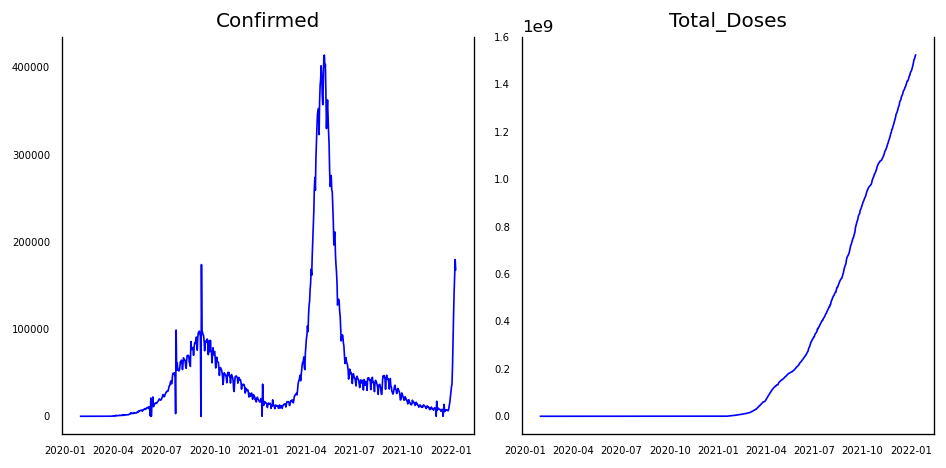

In [94]:
plotting.plot_side_by_side(train=indexed)

<a name=stattests1></a>
## Statistical tests

<a name=jci_init></a>

### Johansen co-integration test

In [95]:
stats_testing.cointegration_test(indexed)

Name   ::  Test Stat > C(95%)    =>   Signif  
 ----------------------------------------
Confirmed ::  24.18     > 12.3212   =>   True
Total_Doses ::  2.31      > 4.1296    =>   False


From JCT, the two time series are not correlated.

<a name=adf_init></a>

### Augmented DF Test

In [96]:
# ADF Test on each column
for name, column in indexed.iteritems():
    stats_testing.run_dicky_fuller(column)
    print('\n')

Observations of Dickey-fuller test
Test Statistic                  -3.015566
p-value                          0.033466
#lags used                      15.000000
number of observations used    696.000000
critical value (1%)             -3.439780
critical value (5%)             -2.865702
critical value (10%)            -2.568986
dtype: float64


Observations of Dickey-fuller test
Test Statistic                   1.935822
p-value                          0.998584
#lags used                      12.000000
number of observations used    699.000000
critical value (1%)             -3.439740
critical value (5%)             -2.865684
critical value (10%)            -2.568977
dtype: float64




The TS is not stationary

<a name=diff_init></a>
## Differencing

## First order differencing

In [97]:
df_diff_1 = indexed.diff().dropna()
# df_diff_1

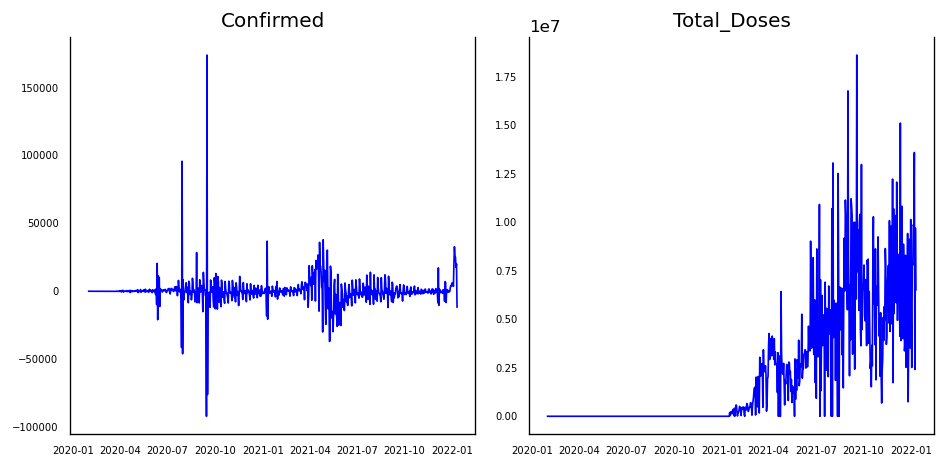

In [98]:
plotting.plot_side_by_side(train=df_diff_1)


In [99]:
stats_testing.cointegration_test(df_diff_1)

Name   ::  Test Stat > C(95%)    =>   Signif  
 ----------------------------------------
Confirmed ::  68.38     > 12.3212   =>   True
Total_Doses ::  1.39      > 4.1296    =>   False


In [100]:
# ADF Test on each column
for name, column in df_diff_1.iteritems():
    stats_testing.run_dicky_fuller(column)
    print('\n')

Observations of Dickey-fuller test
Test Statistic                  -3.591903
p-value                          0.005918
#lags used                      19.000000
number of observations used    691.000000
critical value (1%)             -3.439849
critical value (5%)             -2.865732
critical value (10%)            -2.569002
dtype: float64


Observations of Dickey-fuller test
Test Statistic                  -0.548060
p-value                          0.882292
#lags used                      11.000000
number of observations used    699.000000
critical value (1%)             -3.439740
critical value (5%)             -2.865684
critical value (10%)            -2.568977
dtype: float64




From JCT, the two time series are not correlated.

## Second order differencing

In [101]:
df_diff_2 = df_diff_1.diff().dropna()
df_diff_2

,Confirmed,Total_Doses
Date,,
2020-02-01,0.0,0.0
2020-02-02,1.0,0.0
2020-02-03,-1.0,0.0
2020-02-04,-1.0,0.0
2020-02-05,1.0,0.0
...,...,...
2022-01-06,-6659.0,-86635.0
2022-01-07,-1286.0,3813830.0
2022-01-08,-7240.0,-11185385.0


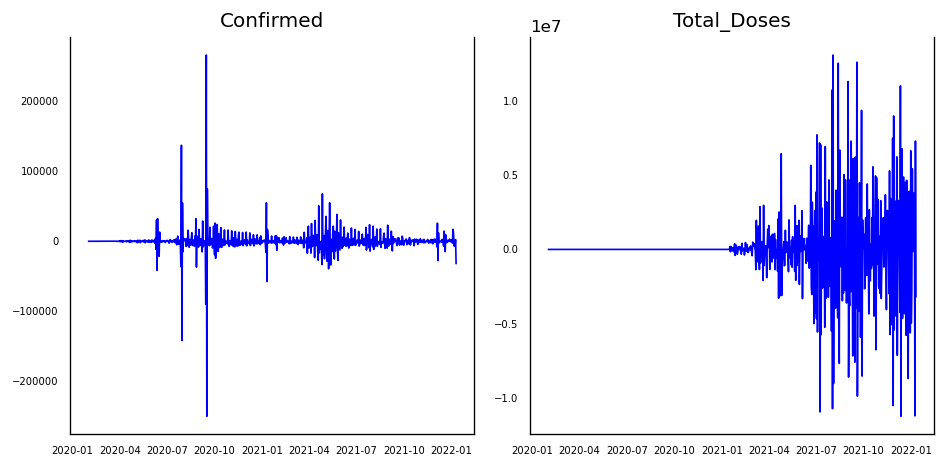

In [102]:
plotting.plot_side_by_side(train=df_diff_2)

In [103]:
# Cointegration test

stats_testing.cointegration_test(df_diff_2)

Name   ::  Test Stat > C(95%)    =>   Signif  
 ----------------------------------------
Confirmed ::  820.14    > 12.3212   =>   True
Total_Doses ::  295.55    > 4.1296    =>   True


From JCT, the two time series are correlated.

In [104]:
# ADF Test on each column
for name, column in df_diff_2.iteritems():
    stats_testing.run_dicky_fuller(column)
    print('\n')

Observations of Dickey-fuller test
Test Statistic                -7.025341e+00
p-value                        6.385996e-10
#lags used                     1.300000e+01
number of observations used    6.960000e+02
critical value (1%)           -3.439780e+00
critical value (5%)           -2.865702e+00
critical value (10%)          -2.568986e+00
dtype: float64


Observations of Dickey-fuller test
Test Statistic                -1.312820e+01
p-value                        1.513692e-24
#lags used                     1.000000e+01
number of observations used    6.990000e+02
critical value (1%)           -3.439740e+00
critical value (5%)           -2.865684e+00
critical value (10%)          -2.568977e+00
dtype: float64




From ADF, both are stationary.

<a name=traintest_init></a>
## Train-test split

### Train-test split

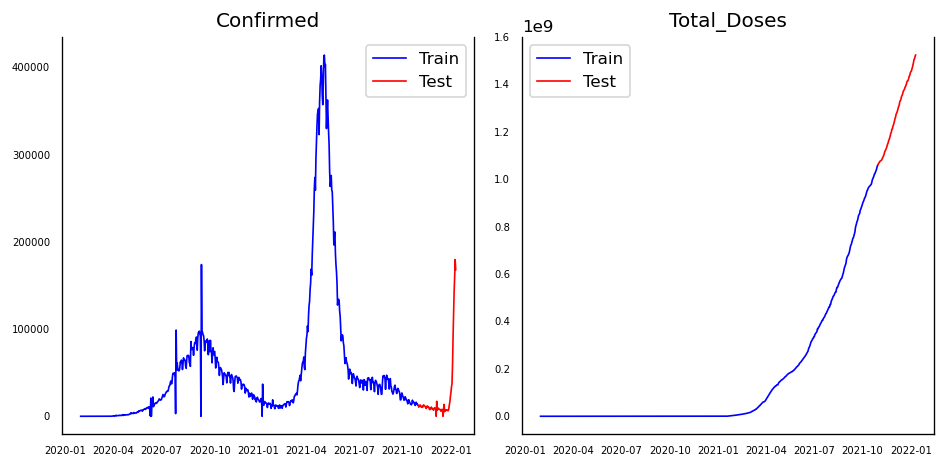

In [105]:
train, test = preprocessing.train_test_split(indexed, fraction=0.9)

plotting.plot_side_by_side(train=train, test=test)

<a name=var_model></a>

# VAR Model

<a name=var_p></a>
## Finding the order p for VAR(p)

Using PACF plot

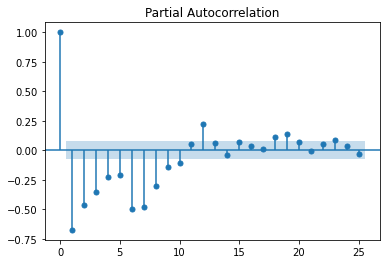

In [106]:
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf

pacf_var_confirmed = plot_pacf(train['Confirmed'].diff().dropna().diff().dropna(), lags=25)

In [107]:
metrics.evaluate_varma_models(train, test, [5, 8, 9, 10], [0], column='Confirmed')

VARMA(5, 0): MSE=7301440143.014, MAPE=856.353, MAE=83843.413
VARMA(8, 0): MSE=101625477760.473, MAPE=3132.937, MAE=309331.964
VARMA(9, 0): MSE=48595666734.458, MAPE=2061.979, MAE=206205.960
VARMA(10, 0): MSE=42829951875.646, MAPE=1930.084, MAE=193695.374

Best VARMA(5, 0): MSE=7301440143.014


<a name=var1></a>
## VAR(5) Model

In [108]:
from statsmodels.tsa.statespace.varmax import VARMAX

model = VARMAX(train, order=(5, 0))
model_fit = model.fit()
forecasted = model_fit.get_prediction(start=len(train), end=len(train)+len(test)-1).predicted_mean

df_forecast = pd.DataFrame(forecasted, index=test.index)
df_forecast.rename(columns = {'Confirmed': 'Confirmed_forecast', 'Total_Doses': 'Total_Doses_forecast'}, inplace=True)

forecasted_conf = df_forecast.join(test)[['Confirmed', 'Confirmed_forecast']]
forecasted_vacc = df_forecast.join(test)[['Total_Doses', 'Total_Doses_forecast']]

# conf = model_fit.conf_int(alpha=0.05)
# forecasted.predicted_mean

In [109]:
model_fit.summary()

Dep. Variable:,"['Confirmed', 'Total_Doses']",No. Observations:,640
Model:,VAR(5),Log Likelihood,-1734633.033
,+ intercept,AIC,3469316.066
Date:,"Thu, 27 Jan 2022",BIC,3469427.603
Time:,18:11:54,HQIC,3469359.359
Sample:,01-30-2020,,
,- 10-30-2021,,
Covariance Type:,opg,,
Ljung-Box (L1) (Q):,"521.38, 634.73",Jarque-Bera (JB):,"354.95, 196.78"
Prob(Q):,"0.00, 0.00",Prob(JB):,"0.00, 0.00"
Heteroskedasticity (H):,"2.38, 0.18",Skew:,"-0.45, 1.26"


In [110]:
# # preprocessing.get_all_attrs(model_fit)

# for attr in dir(model_fit.model):
#     if not attr.startswith('_'):
#         print(attr)

# model_fit.model.k_ar

<a name=diff_plot_var></a>

## Plots of Predictions (Differenced)

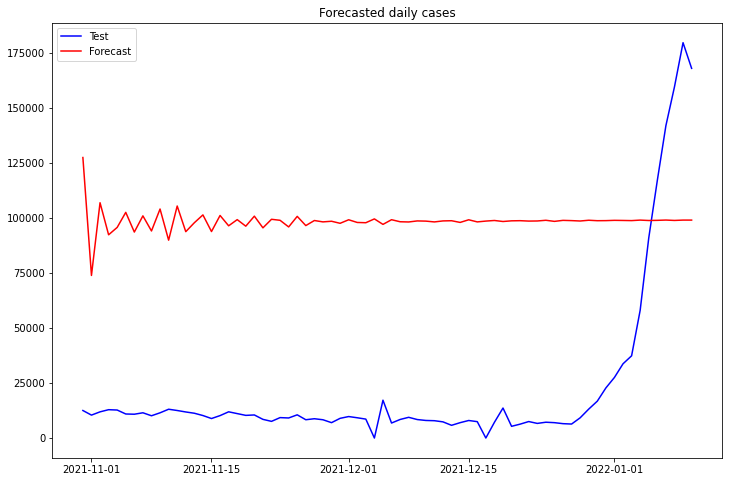

In [111]:
plotting.plot_fore_test(test=test[['Confirmed']], fore=forecasted[['Confirmed']], title='Forecasted daily cases')

<a name=store_var></a>

## Store metrics

In [112]:
results_table = results_table.append({
    'model': preprocessing.get_varma_model_name(model_fit),
    'mse': metrics.mean_squared_error(test['Confirmed'], forecasted['Confirmed']),
    'mape': metrics.MAPE(test['Confirmed'], forecasted['Confirmed']),
    'mae': metrics.mean_absolute_error(test['Confirmed'], forecasted['Confirmed'])
}, ignore_index=True)

results_table

,model,mse,mape,mae
0,VAR(5),7.301440e+09,856.353398,83843.412657


<a name=plot_final_var></a>

## Plot Train, Test, Forecast

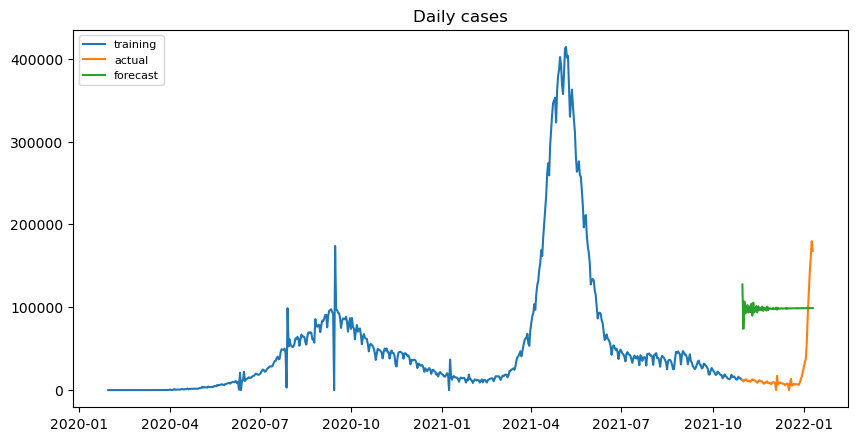

In [113]:
# Plot of daily cases
plotting.plot_train_test_fore(train=train.Confirmed, test=test[['Confirmed']], fore=forecasted[['Confirmed']], title='Daily cases')


Clearly, a VAR model is not good enough to make predictions

<a name=vma_model></a>

# VMA Model

<a name=vma_q></a>
## Find order q of VMA

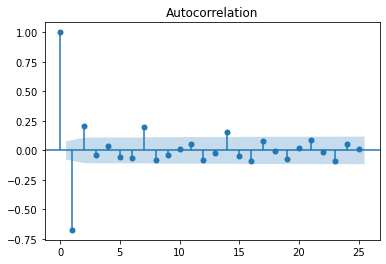

In [114]:
acf_varma_confirmed = plot_acf(train['Confirmed'].diff().dropna().diff().dropna(), lags=25)

In [115]:
metrics.evaluate_varma_models(train, test, [0], [1, 2, 7], column='Confirmed')

VARMA(0, 1): MSE=3635907309.569, MAPE=457.307, MAE=49851.392
VARMA(0, 2): MSE=74006516345818.156, MAPE=10678.614, MAE=1090248.578
VARMA(0, 7): MSE=51760765088.642, MAPE=908.935, MAE=99383.410

Best VARMA(0, 1): MSE=3635907309.569


<a name=vma1></a>

## VMA(1)

In [116]:
model_ma = VARMAX(train, order=(0, 1))
model_fit_ma = model_ma.fit()
forecasted_ma = model_fit_ma.get_prediction(start=len(train), end=len(train)+len(test)-1).predicted_mean

df_forecast_ma = pd.DataFrame(forecasted_ma, index=test.index)
df_forecast_ma.rename(columns = {'Confirmed': 'Confirmed_forecast', 'Total_Doses': 'Total_Doses_forecast'}, inplace=True)

forecasted_conf_ma = df_forecast_ma.join(test)[['Confirmed', 'Confirmed_forecast']]
forecasted_vacc_ma = df_forecast_ma.join(test)[['Total_Doses', 'Total_Doses_forecast']]

# conf = model_fit.conf_int(alpha=0.05)

In [117]:
model_fit_ma.get_prediction(start=len(train), end=len(train)+len(test)-1).predicted_mean

,Confirmed,Total_Doses
2021-10-31,-283238.529979,8.522916e+08
2021-11-01,53552.029693,1.567496e+08
2021-11-02,53552.029693,1.567496e+08
2021-11-03,53552.029693,1.567496e+08
2021-11-04,53552.029693,1.567496e+08
...,...,...
2022-01-06,53552.029693,1.567496e+08
2022-01-07,53552.029693,1.567496e+08
2022-01-08,53552.029693,1.567496e+08
2022-01-09,53552.029693,1.567496e+08


In [118]:
model_fit_ma.summary()

Dep. Variable:,"['Confirmed', 'Total_Doses']",No. Observations:,640
Model:,VMA(1),Log Likelihood,-332670.242
,+ intercept,AIC,665358.484
Date:,"Thu, 27 Jan 2022",BIC,665398.637
Time:,18:12:30,HQIC,665374.069
Sample:,01-30-2020,,
,- 10-30-2021,,
Covariance Type:,opg,,
Ljung-Box (L1) (Q):,"598.45, 423.42",Jarque-Bera (JB):,"126.16, 156.48"
Prob(Q):,"0.00, 0.00",Prob(JB):,"0.00, 0.00"
Heteroskedasticity (H):,"3.66, 18.32",Skew:,"1.09, 0.78"


<a name=diff_plot_vma></a>

## Plots of Predictions (Differenced)

In [119]:
# plot_fore_test(test[['Confirmed']], forecasted_ma[['Confirmed']], title='Diffed Daily cases')

In [120]:
# plot_fore_test(test[['Total_Doses']], forecasted_ma[['Total_Doses']], title='Diffed Daily vaccinations')

<a name=store_vma></a>

## Store metrics

In [121]:
results_table = results_table.append({
    'model': preprocessing.get_varma_model_name(model_fit_ma),
    'mse': metrics.mean_squared_error(test['Confirmed'], forecasted_ma['Confirmed']),
    'mape': metrics.MAPE(test['Confirmed'], forecasted_ma['Confirmed']),
    'mae': metrics.mean_absolute_error(test['Confirmed'], forecasted_ma['Confirmed'])
}, ignore_index=True)

results_table

,model,mse,mape,mae
0,VAR(5),7.301440e+09,856.353398,83843.412657
1,VMA(1),3.635907e+09,457.307130,49851.391979


In [122]:
forecasted_ma

,Confirmed,Total_Doses
2021-10-31,-283238.529979,8.522916e+08
2021-11-01,53552.029693,1.567496e+08
2021-11-02,53552.029693,1.567496e+08
2021-11-03,53552.029693,1.567496e+08
2021-11-04,53552.029693,1.567496e+08
...,...,...
2022-01-06,53552.029693,1.567496e+08
2022-01-07,53552.029693,1.567496e+08
2022-01-08,53552.029693,1.567496e+08
2022-01-09,53552.029693,1.567496e+08


<a name=plot_final_vma></a>

## Plot Train, Test, Forecast

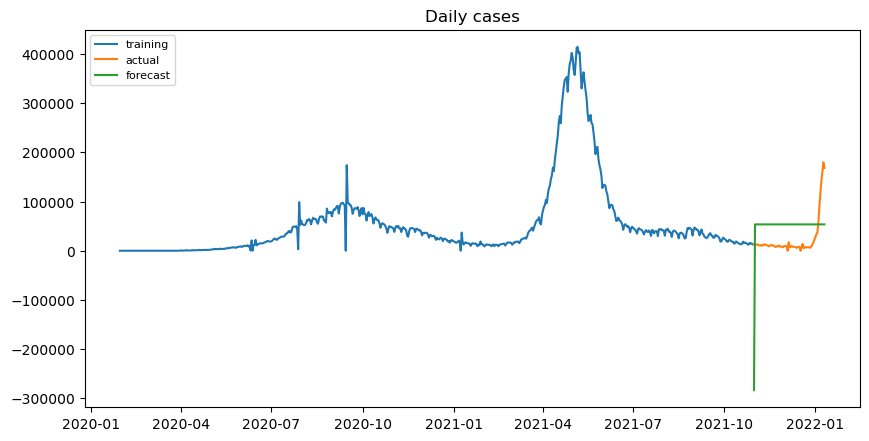

In [123]:
plotting.plot_train_test_fore(train=train.Confirmed, test=test[['Confirmed']], fore=forecasted_ma[['Confirmed']], title='Daily cases')


<a name=varma_model></a>

# VARMA

<a name=varma_pq></a>

## Find order (p, q) of VARMA

PACF/ACF

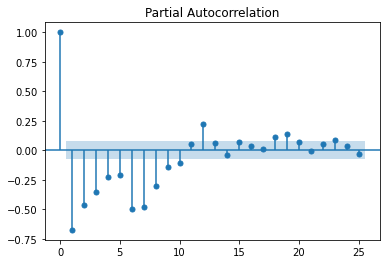

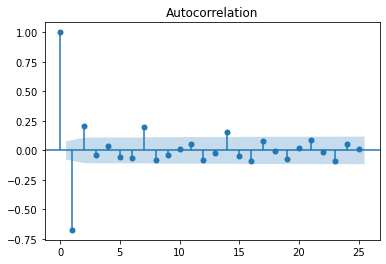

In [124]:
pacf_varma_confirmed = plot_pacf(train['Confirmed'].diff().dropna().diff().dropna(), lags=25)
acf_varma_confirmed = plot_acf(train['Confirmed'].diff().dropna().diff().dropna(), lags=25)

VARIMA(8, 2)

In [125]:
metrics.evaluate_varma_models(train, test, [5, 8, 9, 10], [1, 2, 7], column='Confirmed')

VARMA(5, 1): MSE=10200356986.666, MAPE=1023.460, MAE=98469.005
VARMA(5, 2): MSE=5048247052.552, MAPE=700.343, MAE=69667.296
VARMA(5, 7): MSE=15136127001.782, MAPE=1241.143, MAE=118557.338
VARMA(8, 1): MSE=98521196863.871, MAPE=3082.766, MAE=303150.539
VARMA(8, 2): MSE=84612584927.652, MAPE=2905.348, MAE=287238.963
VARMA(8, 7): MSE=48836050147.129, MAPE=2204.273, MAE=213582.084
VARMA(9, 1): MSE=64606870647.530, MAPE=2545.180, MAE=250183.527
VARMA(9, 2): MSE=162732206973.935, MAPE=3861.480, MAE=386400.821
VARMA(9, 7): MSE=108938894156.052, MAPE=3263.031, MAE=321979.552
VARMA(10, 2): MSE=177022613588.015, MAPE=3964.294, MAE=400558.139
VARMA(10, 7): MSE=291766295467.295, MAPE=5153.862, MAE=516682.743

Best VARMA(5, 2): MSE=5048247052.552


<a name=varma11></a>

## VARMA(5, 2)

In [126]:
model = VARMAX(train, order=(5, 2))
model_fit = model.fit()
yhat = model_fit.forecast(len(test))
# yhat = model_fit.get_prediction(start=len(train), end=len(train)+len(test)-1).predicted_mean


# forecasted_ma = model_fit_ma.get_prediction(start=len(train), end=len(train)+len(test)-1).predicted_mean

df_forecast_varma = pd.DataFrame(yhat, index=test.index)
df_forecast_varma.rename(columns = {'Confirmed': 'Confirmed_forecast', 'Total_Doses': 'Total_Doses_forecast'}, inplace=True)

forecasted_conf_varma = df_forecast_varma.join(test)[['Confirmed', 'Confirmed_forecast']]
forecasted_vacc_varma = df_forecast_varma.join(test)[['Total_Doses', 'Total_Doses_forecast']]
#yhat

<a name=diff_plot_varma></a>

## Plots of Predictions (Differenced)

In [127]:
# plotting.plot_fore_test(test=test[['Confirmed']], fore=yhat[['Confirmed']], title='Diffed Daily cases')

In [128]:
# plotting.plot_fore_test(test=test[['Total_Doses']], fore=yhat[['Total_Doses']], title='Diffed Daily Doses')

<a name=store_varma></a>

## Store metrics

In [129]:
results_table = results_table.append({
    'model': preprocessing.get_varma_model_name(model_fit),
    'mse': metrics.mean_squared_error(test['Confirmed'], yhat['Confirmed']),
    'mape': metrics.MAPE(test['Confirmed'], yhat['Confirmed']),
    'mae': metrics.mean_absolute_error(test['Confirmed'], yhat['Confirmed'])
}, ignore_index=True)

results_table

,model,mse,mape,mae
0,VAR(5),7.301440e+09,856.353398,83843.412657
1,VMA(1),3.635907e+09,457.307130,49851.391979
2,"VARMA(5, 2)",5.048247e+09,700.342774,69667.296182


<a name=plot_final_varma></a>

## Plot Train, Test, Forecast

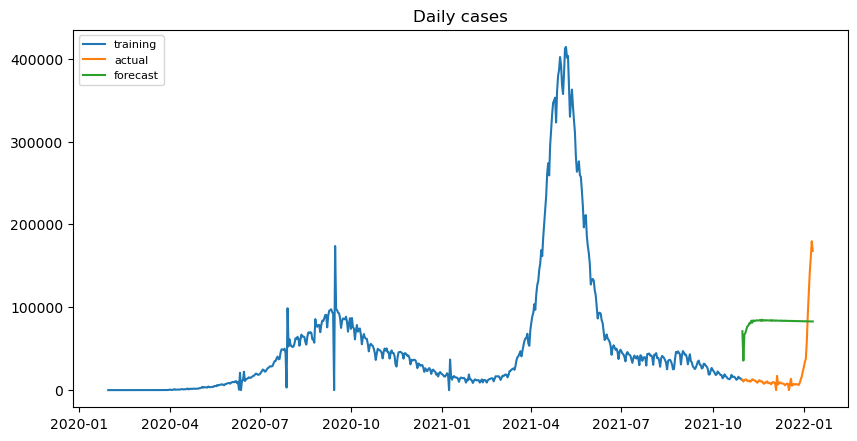

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


In [130]:
# Plot of daily cases
plotting.plot_train_test_fore(train=train.Confirmed, test=test[['Confirmed']], fore=yhat[['Confirmed']], title='Daily cases', figpath='../../figures/varma/india_cases.eps')


<a name=shortterm></a>

# Rolling forecasts

In [131]:
history = train.copy()
predicted = pd.DataFrame(columns=[
    'VAR_Confirmed', 
    'VAR_Total_Doses', 
    'VMA_Confirmed', 
    'VMA_Total_Doses', 
    'VARMA_Confirmed', 
    'VARMA_Total_Doses'
], index=test.index)


# predicted

for t in range(len(test)):
    # 3 models
    var = VARMAX(history, order=(5,0), enforce_stationarity=True)
    vma = VARMAX(history, order=(0,2), enforce_stationarity=True)
    varma = VARMAX(history, order=(5,2), enforce_stationarity=True)
    
    # 3 fitted models
    var_fit = var.fit()
    vma_fit = vma.fit()
    varma_fit = varma.fit()
    
    # Predictions
    yhat_var = var_fit.forecast()
    yhat_vma = vma_fit.forecast()
    yhat_varma = varma_fit.forecast()
    
    # Next index to insert
    # newindex = history.index[-1] + pd.to_timedelta(1, 'D')
    
    # Confirmed cases
    predicted.iloc[t]['VAR_Confirmed'] = yhat_var['Confirmed'].values[0]
    predicted.iloc[t]['VMA_Confirmed'] = yhat_vma['Confirmed'].values[0]
    predicted.iloc[t]['VARMA_Confirmed'] = yhat_varma['Confirmed'].values[0]
    
    # Total doses
    predicted.iloc[t]['VAR_Total_Doses'] = yhat_var['Total_Doses'].values[0]
    predicted.iloc[t]['VMA_Total_Doses'] = yhat_vma['Total_Doses'].values[0]
    predicted.iloc[t]['VARMA_Total_Doses'] = yhat_varma['Total_Doses'].values[0]
    
    history = history.append(test.iloc[t])
    # history[newindex]['Total_Doses'] = test.iloc[t]['Total_Doses']
    
    # print('predicted =', yhat.values, ' ; actual =', test.iloc[t].values)

In [132]:
predicted

,VAR_Confirmed,VAR_Total_Doses,VMA_Confirmed,VMA_Total_Doses,VARMA_Confirmed,VARMA_Total_Doses
Date,,,,,,
2021-10-31,127515.564373,1040126580.470086,-2275654.302415,1010400435.023481,71048.686805,1050117813.50774
2021-11-01,99551.659613,1046117669.878552,-144938.687494,844846999.110701,53348.018198,1061949571.719436
2021-11-02,111747.405849,1065559546.786483,-725223.315798,630834195.585999,123601.687446,1070873899.433154
2021-11-03,86248.637055,1084036402.212948,1286.156881,615771908.239635,38601.211383,1076930891.84468
2021-11-04,77999.068092,1088790481.813069,-251886.516498,622938719.480097,57260.842997,1082475499.079244
...,...,...,...,...,...,...
2022-01-06,109888.873849,1367684737.099372,-46183.507074,868202046.404647,121794.48664,1411121524.086956
2022-01-07,201439.776997,1308918515.785863,-31329.924044,868942965.307489,115271.070592,1391742744.245286
2022-01-08,187011.032002,1280569496.791375,-62710.561042,877121132.370981,191315.146508,1403683834.908103


<a name=var_roll></a>

## VAR(8)

In [133]:
# plotting.plot_fore_test(test=test, fore=predicted[['VAR_Confirmed', 'VAR_Total_Doses']], title='Confirmed vs Predicted')

In [134]:
# fore_original_4_var

In [135]:
results_table = results_table.append({
    'model': preprocessing.get_varma_model_name(var_fit) + ' - rolling',
    'mse': metrics.mean_squared_error(test['Confirmed'], predicted['VAR_Confirmed']),
    'mape': metrics.MAPE(test['Confirmed'], predicted['VAR_Confirmed']),
    'mae': metrics.mean_absolute_error(test['Confirmed'], predicted['VAR_Confirmed'])
}, ignore_index=True)

results_table

,model,mse,mape,mae
0,VAR(5),7.301440e+09,856.353398,8.384341e+04
1,VMA(1),3.635907e+09,457.307130,4.985139e+04
2,"VARMA(5, 2)",5.048247e+09,700.342774,6.966730e+04
3,VAR(5) - rolling,5.785455e+13,13058.826925,1.045543e+06


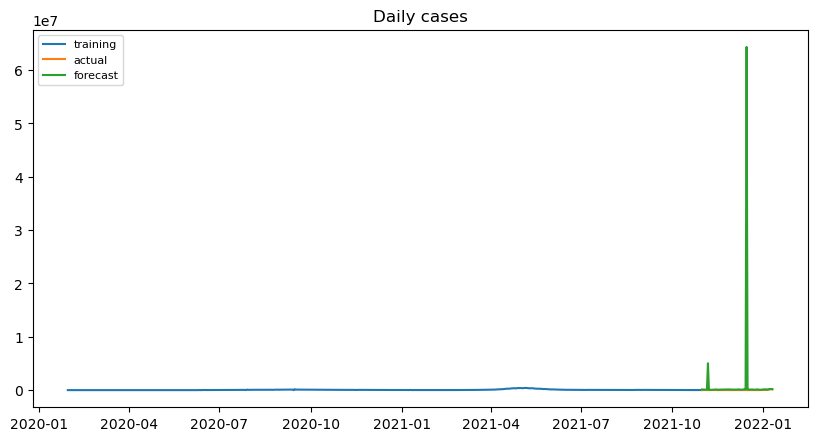

In [136]:
plotting.plot_train_test_fore(train=train.Confirmed, test=test[['Confirmed']], fore=predicted[['VAR_Confirmed']], title='Daily cases')#, figpath='../../figures/varma/india_cases.eps')


<a name=vma_roll></a>

## VMA(1)

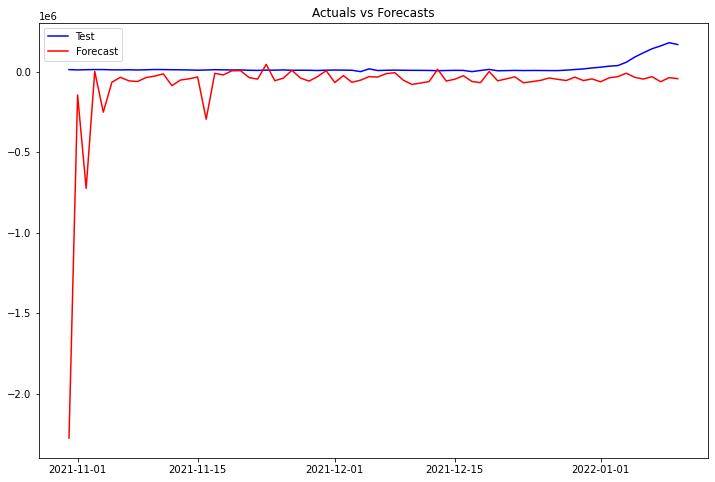

In [137]:
plotting.plot_fore_test(test=test['Confirmed'], fore=predicted['VMA_Confirmed'], title='Actuals vs Forecasts')

In [138]:
results_table = results_table.append({
    'model': preprocessing.get_varma_model_name(vma_fit) + ' - rolling',
    'mse': metrics.mean_squared_error(test['Confirmed'], predicted['VMA_Confirmed']),
    'mape': metrics.MAPE(test['Confirmed'], predicted['VMA_Confirmed']),
    'mae': metrics.mean_absolute_error(test['Confirmed'], predicted['VMA_Confirmed'])
}, ignore_index=True)

results_table

,model,mse,mape,mae
0,VAR(5),7.301440e+09,856.353398,8.384341e+04
1,VMA(1),3.635907e+09,457.307130,4.985139e+04
2,"VARMA(5, 2)",5.048247e+09,700.342774,6.966730e+04
3,VAR(5) - rolling,5.785455e+13,13058.826925,1.045543e+06
4,VMA(2) - rolling,8.850434e+10,902.835660,1.107337e+05


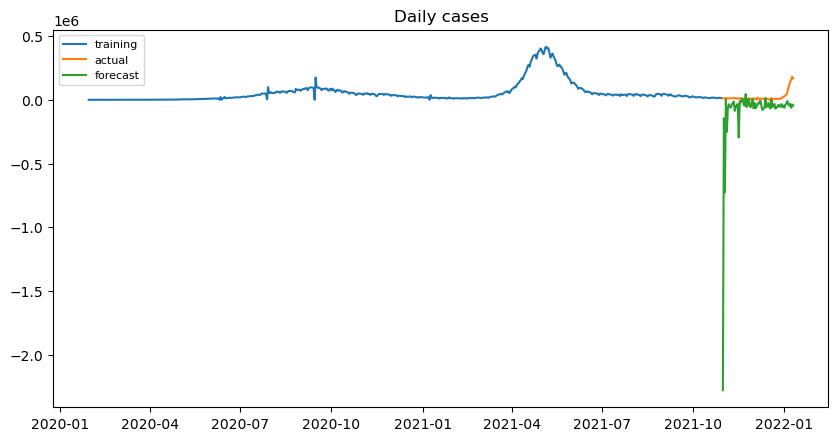

In [139]:
plotting.plot_train_test_fore(train=train.Confirmed, test=test[['Confirmed']], fore=predicted[['VMA_Confirmed']], title='Daily cases')#, figpath='../../figures/varma/india_cases.eps')


<a name=varma_roll></a>

## VARMA(1,1)

In [140]:
# fore_original_4_varma

In [141]:
results_table = results_table.append({
    'model': preprocessing.get_varma_model_name(varma_fit) + ' - rolling',
    'mse': metrics.mean_squared_error(test['Confirmed'], predicted['VARMA_Confirmed']),
    'mape': metrics.MAPE(test['Confirmed'], predicted['VARMA_Confirmed']),
    'mae': metrics.mean_absolute_error(test['Confirmed'], predicted['VARMA_Confirmed'])
}, ignore_index=True)

results_table

,model,mse,mape,mae
0,VAR(5),7.301440e+09,856.353398,8.384341e+04
1,VMA(1),3.635907e+09,457.307130,4.985139e+04
2,"VARMA(5, 2)",5.048247e+09,700.342774,6.966730e+04
3,VAR(5) - rolling,5.785455e+13,13058.826925,1.045543e+06
4,VMA(2) - rolling,8.850434e+10,902.835660,1.107337e+05
5,"VARMA(5, 2) - rolling",4.578871e+09,622.091702,5.886780e+04


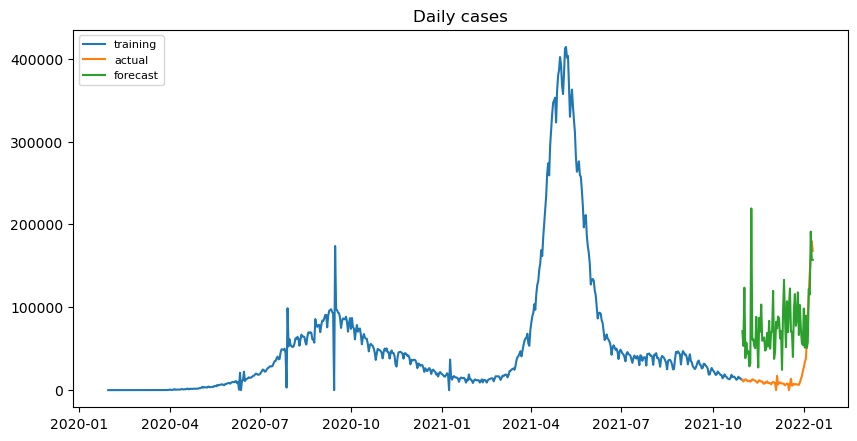

In [142]:
plotting.plot_train_test_fore(train=train.Confirmed, test=test[['Confirmed']], fore=predicted[['VARMA_Confirmed']], title='Daily cases')#, figpath='../../figures/varma/india_cases.eps')


<a name=final_results></a>

# Final Results

In [143]:
results_table

,model,mse,mape,mae
0,VAR(5),7.301440e+09,856.353398,8.384341e+04
1,VMA(1),3.635907e+09,457.307130,4.985139e+04
2,"VARMA(5, 2)",5.048247e+09,700.342774,6.966730e+04
3,VAR(5) - rolling,5.785455e+13,13058.826925,1.045543e+06
4,VMA(2) - rolling,8.850434e+10,902.835660,1.107337e+05
5,"VARMA(5, 2) - rolling",4.578871e+09,622.091702,5.886780e+04
